<a href="https://colab.research.google.com/github/adarsh-meher/Kaggle---Predict-Real-disaster-tweets/blob/master/Kaggle_Real_or_not_Disaster_Tweet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!git clone https://github.com/adarsh-meher/Kaggle---Predict-Real-disaster-tweets.git
import os
os.chdir('/content/Kaggle---Predict-Real-disaster-tweets/')

Cloning into 'Kaggle---Predict-Real-disaster-tweets'...
remote: Enumerating objects: 23, done.
remote: Counting objects: 100% (23/23), done.
remote: Compressing objects: 100% (22/22), done.
remote: Total 23 (delta 7), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (23/23), done.


In [0]:
os.listdir(os.getcwd())

['train.csv',
 'sample_submission.csv',
 '.git',
 'Kaggle_Real_or_not_Disaster_Tweet.ipynb',
 'README.md',
 'test.csv']

In [0]:
!pip install fasttext
!pip install fastai
!pip install wordcloud
!pip install transformers
!pip install torchtext

     |████████████████████████████████| 61kB 9.4MB/s 
  Created wheel for fasttext: filename=fasttext-0.9.1-cp36-cp36m-linux_x86_64.whl size=2385708 sha256=e19dba7571d7b5f2fd42af97cd5579a85bdb60076a889cf5a497dbcaa19fc109
  Stored in directory: /root/.cache/pip/wheels/9f/f0/04/caa82c912aee89ce76358ff954f3f0729b7577c8ff23a292e3
Successfully built fasttext
     |████████████████████████████████| 573kB 41.9MB/s 
     |████████████████████████████████| 1.0MB 42.4MB/s 
     |████████████████████████████████| 3.7MB 42.3MB/s 
     |████████████████████████████████| 890kB 53.8MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.41-cp36-none-any.whl size=893334 sha256=180967454b6d09a0a33bb7314ba9577006867bff6904ff214d8c79737927cabb
  Stored in directory: /root/.cache/pip/wheels/22/5a/d4/b020a81249de7dc63758a34222feaa668dbe8ebfe9170cc9b1
Successfully built sacremoses


In [0]:
import pandas as pd
import numpy as np
import spacy as S
import gensim as G
import fasttext as ft
import fastai as fai
import hyperopt as hopt
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sb
from wordcloud import  WordCloud, STOPWORDS , ImageColorGenerator
import nltk
from tqdm import tqdm

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
#### List of contractions
contractions = { 
"ain't": "am not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he had",
"he'd've": "he would have",
"he'll": "he shall",
"he'll've": "he shall have",
"he's": "he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how is",
"I'd": "I had",
"I'd've": "I would have",
"I'll": "I shall",
"I'll've": "I shall have",
"I'm": "I am",
"I've": "I have",
"isn't": "is not",
"it'd": "it had",
"it'd've": "it would have",
"it'll": "it shall",
"it'll've": "it shall have",
"it's": "it has",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she had",
"she'd've": "she would have",
"she'll": "she shall",
"she'll've": "she shall have",
"she's": "she has",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so as",
"that'd": "that would",
"that'd've": "that would have",
"that's": "that has",
"there'd": "there had",
"there'd've": "there would have",
"there's": "there has",
"they'd": "they had",
"they'd've": "they would have",
"they'll": "they shall",
"they'll've": "they shall have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we had",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what shall",
"what'll've": "what shall have",
"what're": "what are",
"what's": "what has",
"what've": "what have",
"when's": "when has",
"when've": "when have",
"where'd": "where did",
"where's": "where has",
"where've": "where have",
"who'll": "who shall",
"who'll've": "who shall have",
"who's": "who has",
"who've": "who have",
"why's": "why has",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you had",
"you'd've": "you would have",
"you'll": "you shall",
"you'll've": "you shall have",
"you're": "you are",
"you've": "you have"
}

In [0]:
train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")

In [0]:
train_data.columns

Index(['id', 'keyword', 'location', 'text', 'target'], dtype='object')

In [0]:
train_data.set_index(['id'],inplace=True)
train_data.drop_duplicates(inplace = True)
train_data.reset_index(inplace= True)

#test_data.set_index(['id'],inplace=True)
#test_data.drop_duplicates(inplace = True)
#test_data.reset_index(inplace= True)

# **EDA and Text Analysis**

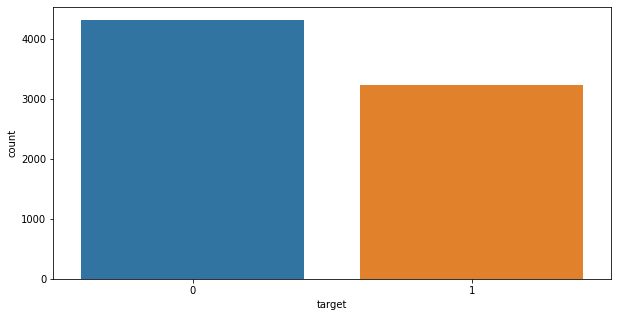

In [0]:
##### Distribution of 1/0 in train

plt.figure(figsize = (10,5))
sb.countplot(x = 'target',data = train_data)
plt.show()

### No imbalance in target distribution.

In [0]:
##### Train data summary
def data_summary(data):
  df1 = pd.DataFrame(columns = ['Column name','NA Present','Number of Uniques Except NA','Most Common Category','Least Common Category'],index = range(data.shape[1]))
  for i,c in enumerate(data.columns.tolist()):
    df1.loc[i,'Column name'] = c
    df1.loc[i,'NA Present'] = data[pd.isna(data[c])].shape[0]
    df1.loc[i,'Number of Uniques Except NA'] = data[~pd.isna(data[c])][c].nunique()
    df1.loc[i,'Least Common Category'] = data[~pd.isna(data[c])][c].value_counts().argmin()
    df1.loc[i,'Most Common Category'] = data[~pd.isna(data[c])][c].value_counts().argmax()
  return df1


In [0]:
data_summary(train_data)

,Column name,NA Present,Number of Uniques Except NA,Most Common Category,Least Common Category
0,id,0,7561,0,0
1,keyword,61,221,0,220
2,location,2500,3341,0,522
3,text,0,7503,0,48
4,target,0,2,0,1


In [0]:
data_summary(test_data)

,Column name,NA Present,Number of Uniques Except NA,Most Common Category,Least Common Category
0,id,0,3263,0,0
1,keyword,26,221,0,220
2,location,1105,1602,0,206
3,text,0,3243,0,19


In [0]:
#### counts of texts to check duplicate texts. We can then look at other attributes of duplicate texts to see what they differ in.
train_data['text'].value_counts().sort_values(ascending = False)

11-Year-Old Boy Charged With Manslaughter of Toddler: Report: An 11-year-old boy has been charged with manslaughter over the fatal sh...       5
Madhya Pradesh Train Derailment: Village Youth Saved Many Lives                                                                                3
that horrible sinking feeling when youÛªve been at home on your phone for a while and you realise its been on 3G this whole time              3
The Prophet (peace be upon him) said 'Save yourself from Hellfire even if it is by giving half a date in charity.'                             3
He came to a land which was engulfed in tribal war and turned it into a land of peace i.e. Madinah. #ProphetMuhammad #islam                    3
                                                                                                                                              ..
@_itzSteven @xdojjjj @whopper_jr_760 huh?? me you and leo started that last year and ever since people blaze it in the back??     

In [0]:
#### look into some of repeated texts and see their other attributes
t1 = train_data['text'].value_counts()
repeated_tweets = t1[t1>1].index.values.tolist()
print("Number of repeated tweets : %s" % (len(repeated_tweets)))
t2 = train_data[train_data['text'].isin(repeated_tweets)]
t2

#### We can see that for some texts the target is same but they differ in location. For others we have different target values for same text.

Number of repeated tweets : 48


,id,keyword,location,text,target
606,881,bioterrorism,NaN,To fight bioterrorism sir.,1
620,898,bioterrorism,NaN,To fight bioterrorism sir.,0
1128,1634,bombing,NaN,Japan on Thursday marks the 70th anniversary o...,1
1150,1665,bombing,Singapore,Japan on Thursday marks the 70th anniversary o...,1
1166,1689,bridge%20collapse,"Mumbai , India",Warne shocked over Australia's epic collapse a...,1
...,...,...,...,...,...
7548,10855,NaN,NaN,Evacuation order lifted for town of Roosevelt:...,1
7555,10867,NaN,NaN,#stormchase Violent Record Breaking EF-5 El Re...,1
7557,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7558,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1


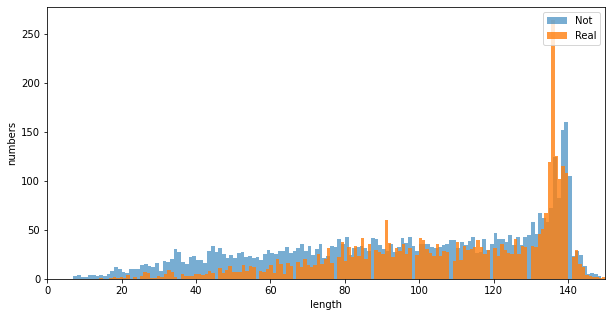

In [0]:
##### Number of characters in tweet

train_data['len_char'] = train_data['text'].apply(lambda x : len(x))
test_data['len_char'] = test_data['text'].apply(lambda x : len(x))

plt.figure(figsize = (10,5))
bins = 150
plt.hist(train_data[train_data['target'] == 0]['len_char'], alpha = 0.6, bins=bins, label='Not')
plt.hist(train_data[train_data['target'] == 1]['len_char'], alpha = 0.8, bins=bins, label='Real')
plt.xlabel('length')
plt.ylabel('numbers')
plt.legend(loc='upper right')
plt.xlim(0,150)
plt.show()


##### The distribution of length of chars is approximately similar

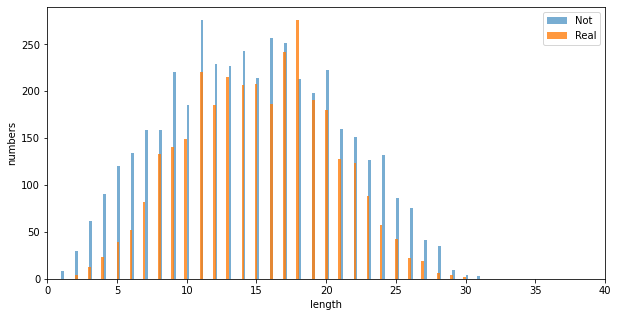

In [0]:
##### Analyzing distribution of number of words in 1/0 tweets

train_data['num_words'] = train_data['text'].apply(lambda x : len(x.split()))
test_data['num_words'] = test_data['text'].apply(lambda x : len(x.split()))

plt.figure(figsize = (10,5))
plt.hist(train_data[train_data['target'] == 0]['num_words'], alpha = 0.6, bins=bins, label='Not')
plt.hist(train_data[train_data['target'] == 1]['num_words'], alpha = 0.8, bins=bins, label='Real')
plt.xlabel('length')
plt.ylabel('numbers')
plt.legend(loc='upper right')
plt.xlim(0,40)
plt.show()

#### The distribution is approximately similar

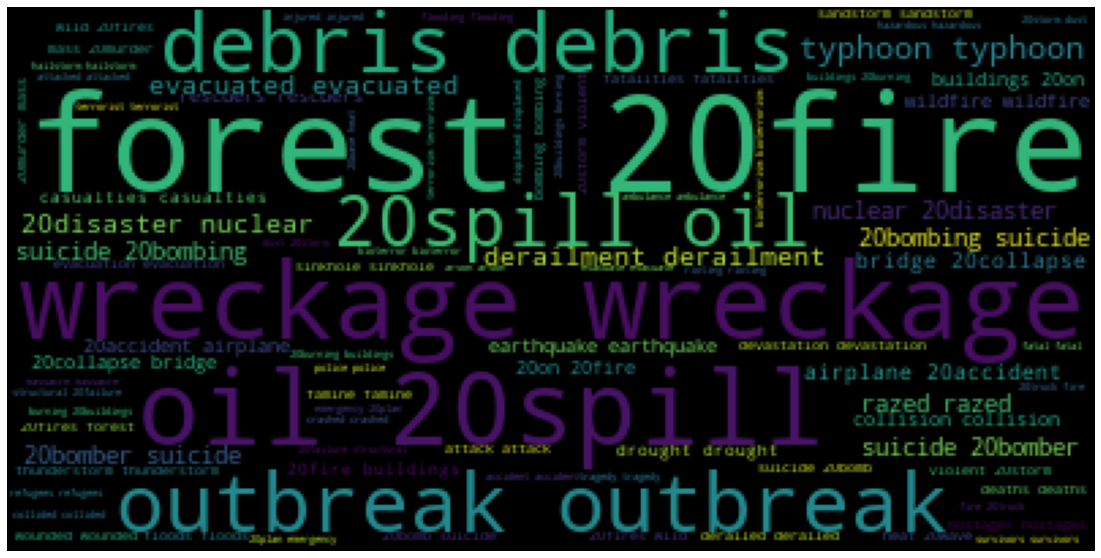

In [0]:
#### Wordcloud of keywords for trget distribution
keywords_1 = train_data[(train_data['target'] == 1) & (~pd.isna(train_data['keyword']))]['keyword'].values.tolist()
keywords_0 = train_data[(train_data['target'] == 0) & (~pd.isna(train_data['keyword']))]['keyword'].values.tolist()


#### Wordcloud for keywords belonging to target 1
plt.figure(figsize=(20,10))
word_cloud = WordCloud(
                          background_color='black',
                          max_font_size = 80
                         ).generate(" ".join(keywords_1))
plt.imshow(word_cloud)
plt.axis('off')
plt.show()


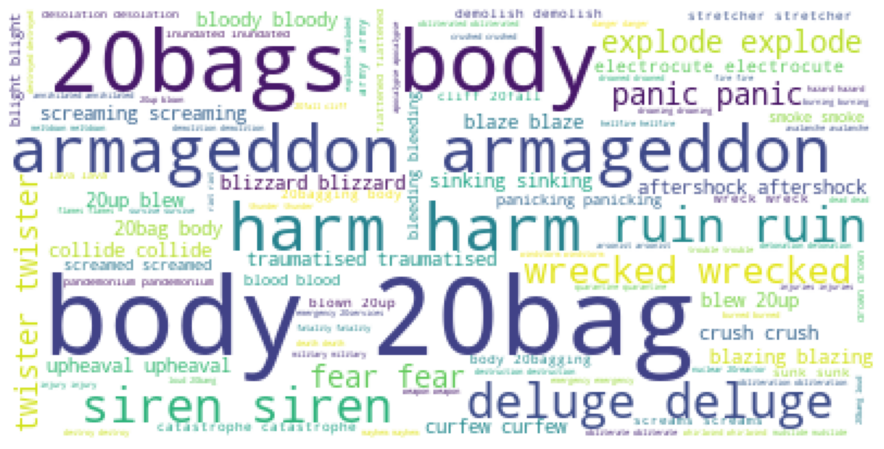

In [0]:
#### Wordcloud of keywords belonging to target 0
plt.figure(figsize=(20,8))
word_cloud = WordCloud(
                          background_color='white',
                          max_font_size = 50
                         ).generate(" ".join(keywords_0))
plt.imshow(word_cloud)
plt.axis('off')
plt.show()


# **Feature Engineering and text cleaning**

In [0]:
##### Removing stopwords, punctuations and extracting hashtags,@ and http texts.
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer,WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from nltk.probability import FreqDist
from string import punctuation

nltk.download("stopwords")
nltk.download("punkt")
nltk.download('averaged_perceptron_tagger')

stop_words = set(stopwords.words("english"))
ps = PorterStemmer()
wnl = WordNetLemmatizer()


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [0]:

import re
import string
nlp = S.load("en_core_web_sm")

text_with_postag = {}
text_with_depparse = {}
text_with_ner = {}

def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

def cleaning_tweet(x):
  
  ####removing emojis
  x = remove_emoji(x)
  url = re.compile(r'https?://\S+|www\.\S+')
  html=re.compile(r'<.*?>')

  x = url.sub(r'',x)
  x = html.sub(r'',x)

  ### extract contractions
  x1 = [ contractions[j] if j in list(contractions.keys()) else j for i in sent_tokenize(x) for j in word_tokenize(i)  ]
  
  ### removing stopwords
  x2 = [ i for i in x1 if i not in stop_words]
  
  ### removing punctuations
  x3  = " ".join([w for w in x2  if w not in string.punctuation])
  x4 = re.sub('[0-9]+', '', x3)
  
  doc = nlp(x4)
  
  ### clean text
  clean_text = [ token.lemma_.lower() for token in doc if token.lemma_.lower() not in string.punctuation ]
  
  return clean_text

In [0]:
train_data['flag'] = ['train']*train_data.shape[0]
test_data['flag'] = ['test']*test_data.shape[0]
total_data = pd.concat([train_data.drop(['target'],axis = 1),test_data],axis = 0)

In [0]:
total_data['clean_text'] = total_data['text'].apply(lambda u : cleaning_tweet(u))

In [0]:
target = train_data['target']

In [0]:
total_data['digit_pres'] = total_data['text'].apply(lambda x : 1 if len(re.findall('[0-9]+',x))>0 else 0)
url = re.compile(r'https?://\S+|www\.\S+')
html=re.compile(r'<.*?>')
total_data['html_link_pres'] = total_data['text'].apply(lambda x : 1 if len(html.findall(x))>0 else 0)     ### removing html
total_data['url_pres'] = total_data['text'].apply(lambda x : 1 if len(url.findall(x))>0 else 0)    ### removing url

In [0]:
def key_vars(x,key,return_pos = True):
  if pd.isna(key):
    if return_pos:
      return -1
    else:
      return 0
  else:
    pos_of_keyword = list(x.split()).index(key)/len(list(x.split())) if key in list(x.split()) else 0
    num_occur_key = sum([1 if j==key  else 0 for j in list(x.split()) ])
    if return_pos:
      return pos_of_keyword
    else:
      return num_occur_key

total_data['pos_of_keyword'] = total_data[['text','keyword']].apply(lambda x : key_vars(x[0],x[1]),axis = 1)     ### removing html
total_data['num_occur_key'] = total_data[['text','keyword']].apply(lambda x : key_vars(x[0],x[1],return_pos=False),axis = 1)    ### removing url

In [0]:
total_data['text_with_postag'] = total_data['clean_text'].apply(lambda x : [ '/'.join(list(i)) for i in [ (token.text,token.pos_) for token in nlp(' '.join(x))] ])

In [0]:
total_data['text_with_depparse'] = total_data['clean_text'].apply(lambda x : [ '/'.join(list(i)) for i in [ (token.text,token.dep_) for token in nlp(' '.join(x))] ])

In [0]:
total_data['text_with_ner'] = total_data['clean_text'].apply(lambda x : [ '/'.join(list(i)) for i in [ (token.text,token.label_) for token in nlp(' '.join(x)).ents] ])

In [0]:
##### Final train/test data.
train_data = total_data[total_data['flag'] == 'train']
test_data = total_data[total_data['flag'] == 'test']

In [0]:
#pd.concat([train_data,target],axis = 1).to_csv('Train_Real_Tweets.csv',index = False)
#test_data.to_csv('Test_Real_Tweets.csv',index = False)

# **Splitting train into train/validation**

In [0]:
train_data['clean_text_joined'] = train_data['clean_text'].apply(lambda x : ' '.join([ i for i in x if i != '-pron-' ]))
test_data['clean_text_joined'] = test_data['clean_text'].apply(lambda x : ' '.join([ i for i in x if i != '-pron-' ]))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [0]:
from sklearn.model_selection import train_test_split
x_train,x_val,y_train,y_val = train_test_split(train_data['clean_text_joined'],target,test_size = 0.25)
x_train = pd.DataFrame(x_train,index = range(x_train.shape[0]))
x_train.rename(columns = {'clean_text_joined' : 'text'},inplace = True)
y_train.index = x_train.index
x_val = pd.DataFrame(x_val,index = range(x_val.shape[0]))
x_val.rename(columns = {'clean_text_joined' : 'text'},inplace = True)
y_val.index = x_val.index

# **Classification with PyTorch**

In [0]:
import torch as T
from torch import nn
from torchtext.data import Field,BucketIterator,TabularDataset,LabelField
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

In [0]:
text_field = Field(tokenize=word_tokenize,lower = True,stop_words=stop_words)
label_field = LabelField(dtype = T.float)
datafields = [('target',label_field),('clean_text_joined',text_field)]

In [0]:
pd.concat([target,train_data['clean_text_joined']],axis = 1).to_csv('TText_Train.csv',index = False)
pd.concat([pd.Series([0]*test_data.shape[0],name = 'target'),test_data['clean_text_joined']],axis = 1).to_csv('TText_Test.csv',index = False)

In [0]:
train,test = TabularDataset.splits(path = os.getcwd(),train = 'TText_Train.csv',test = 'TText_Test.csv',format = 'csv',fields = datafields,skip_header = True)

In [0]:
text_field.build_vocab(train,max_size = 5000)
label_field.build_vocab(train)

print('Size of vocabulary : %s' % (len(text_field.vocab)))
print('Size of vocabulary : %s' % (len(label_field.vocab)))

Size of vocabulary : 5002
Size of vocabulary : 2


In [0]:
########## Creating batch iterator
batch_size = 100
train_batch,test_batch = BucketIterator.splits((train,test),batch_size=batch_size,sort_key = lambda x : len(x.clean_text_joined),sort_within_batch = False)

In [0]:
class RNN(nn.Module):
  def __init__(self,input_dim,embed_dim,hidden_dim,output_dim):
    super(RNN,self).__init__()

    self.embed = nn.Embedding(input_dim,embed_dim)
    self.rnn = nn.LSTM(embed_dim,hidden_dim)
    self.output = nn.Linear( hidden_dim,output_dim)

  def forward(self,text):
    embeds = self.embed(text)
    output,(hidden,_) = self.rnn(embeds)
    hidden_vec = hidden.squeeze(0)

    #assert output[-1,:,:] == hidden_vec
    return self.output(hidden_vec)


In [0]:
input_dim = len(text_field.vocab)
embed_dim = 200
hidden_dim = 300
output_dim = len(label_field.vocab)-1

In [0]:
model = RNN(input_dim,embed_dim,hidden_dim,output_dim)

from torch.optim import Adam
optimizer = Adam(model.parameters(),lr = 0.0001)

criterion = nn.BCEWithLogitsLoss()

In [0]:
def train(model,iterator,optimizer,criterion):
  epoch_loss = 0
  epoch_acc = 0
  model.train()

  for batch in iterator:
    optimizer.zero_grad()
    preds = model(batch.clean_text_joined).squeeze(1)
    loss = criterion(preds,batch.target)

    round_preds = T.round(T.sigmoid(preds))
    correct_preds = (round_preds == batch.target).float()
    
    acc = correct_preds.sum()/len(correct_preds)

    loss.backward()
    optimizer.step()

    epoch_loss += loss.item()
    epoch_acc += acc.item()

  return epoch_loss/len(iterator),epoch_acc/len(iterator)
  

In [0]:
epochs = 10
for i in range(epochs):
  train_loss,train_acc = train(model,train_batch,optimizer,criterion)
  print(f'| Epoch : {i+1:02}  |  Train Loss : {train_loss:.3f}   |  Train Accuracy : {train_acc*100:.2f}% |')

| Epoch : 01  |  Train Loss : 0.683   |  Train Accuracy : 57.33% |
| Epoch : 02  |  Train Loss : 0.674   |  Train Accuracy : 59.25% |
| Epoch : 03  |  Train Loss : 0.637   |  Train Accuracy : 64.67% |
| Epoch : 04  |  Train Loss : 0.562   |  Train Accuracy : 72.79% |
| Epoch : 05  |  Train Loss : 0.510   |  Train Accuracy : 76.48% |
| Epoch : 06  |  Train Loss : 0.468   |  Train Accuracy : 79.31% |
| Epoch : 07  |  Train Loss : 0.443   |  Train Accuracy : 80.91% |
| Epoch : 08  |  Train Loss : 0.417   |  Train Accuracy : 82.24% |
| Epoch : 09  |  Train Loss : 0.387   |  Train Accuracy : 84.07% |
| Epoch : 10  |  Train Loss : 0.350   |  Train Accuracy : 86.47% |
